In [36]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
# Load data
train_df = pd.read_csv('/app/data/playground-series-s5e3/train.csv')
test_df = pd.read_csv('/app/data/playground-series-s5e3/test.csv')

# Prepare features and target
X = train_df.drop(['id', 'rainfall'], axis=1)
y = train_df['rainfall']
X_test_full = test_df.drop(['id'], axis=1)

# Enhanced data preprocessing pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Create preprocessing pipeline
preprocessor = make_pipeline(
    SimpleImputer(strategy='median', add_indicator=True),
    StandardScaler()
)

# Apply preprocessing
X = preprocessor.fit_transform(X)
X_test_full = preprocessor.transform(X_test_full)

# Convert to numpy arrays and ensure proper data types
X = np.asarray(X, dtype=np.float32)
X_test_full = np.asarray(X_test_full, dtype=np.float32)

# Detailed data validation with logging
def validate_data(data, name):
    print(f'\nValidating {name}...')
    print(f'Shape: {data.shape}')
    print(f'Memory usage: {data.nbytes / 1024 / 1024:.2f} MB')
    
    # Check for NaN values
    nan_count = np.isnan(data).sum()
    if nan_count > 0:
        nan_indices = np.where(np.isnan(data))
        print(f'NaN values found in columns: {np.unique(nan_indices[1])}')
        print(f'NaN counts per column: {np.isnan(data).sum(axis=0)}')
        raise ValueError(
            f'Found {nan_count} NaN values in {name} at indices: {nan_indices}'
        )
    
    # Check for infinite values
    inf_count = np.isinf(data).sum()
    if inf_count > 0:
        inf_indices = np.where(np.isinf(data))
        print(f'Infinite values found in columns: {np.unique(inf_indices[1])}')
        raise ValueError(
            f'Found {inf_count} infinite values in {name} at indices: {inf_indices}'
        )
    
    # Check value ranges
    print(f'Min values: {np.min(data, axis=0)}')
    print(f'Max values: {np.max(data, axis=0)}')
    print(f'Mean values: {np.mean(data, axis=0)}')
    print(f'Std values: {np.std(data, axis=0)}')
    print(f'Validation of {name} completed successfully\n')

validate_data(X, 'training features')
validate_data(X_test_full, 'test features')
validate_data(y.values.reshape(-1, 1), 'training labels')


Validating training features...
Shape: (2190, 11)
Memory usage: 0.09 MB
Min values: [-1.7013608 -2.5825882 -2.824286  -3.1703448 -3.592372  -3.9254372
 -5.5183015 -4.0905757 -1.0328039 -1.1860244 -1.7586906]
Max values: [1.7593873 3.7137563 1.7042515 1.445437  1.5084938 1.1812369 2.0468948
 1.3471073 2.304668  2.439694  3.8089914]
Mean values: [ 7.6751183e-09 -4.3827445e-08 -3.4782985e-08 -3.1571410e-09
 -2.7788284e-08 -5.5113882e-09  1.4560952e-08 -3.8756628e-08
 -1.0614526e-09 -5.1235499e-08  4.7139380e-08]
Std values: [0.9999997  1.0000007  0.9999986  1.0000005  0.99999976 1.0000002
 0.99999934 0.9999985  0.9999979  0.9999996  0.999999  ]
Validation of training features completed successfully


Validating test features...
Shape: (730, 11)
Memory usage: 0.03 MB
Min values: [-1.7013608 -2.4057248 -3.3549738 -3.457634  -3.5528302 -3.8686965
 -5.5183015 -4.201549  -1.0328039 -1.1860244 -1.7485859]
Max values: [1.7593873 3.2892835 1.6688724 1.5028948 1.3700982 1.1812369 2.0468948
 1.347

In [38]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [39]:
# Initialize logistic regression model
model = LogisticRegression(random_state=42, max_iter=1000)

In [40]:
# 10-fold cross validation
cv_scores = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
print(f'Cross-validation accuracy scores: {cv_scores}')
print(f'Mean CV accuracy: {cv_scores.mean():.4f}')

Cross-validation accuracy scores: [0.86931818 0.80113636 0.86285714 0.85142857 0.86285714 0.86285714
 0.86857143 0.92       0.86857143 0.85142857]
Mean CV accuracy: 0.8619


In [41]:
# Train model on full training set
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Make predictions on full test set
test_pred = model.predict(X_test_full)
test_pred_proba = model.predict_proba(X_test_full)[:, 1]

In [42]:
# Evaluate model
print('Validation Set Metrics:')
print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print(f'Precision: {precision_score(y_test, y_pred):.4f}')
print(f'Recall: {recall_score(y_test, y_pred):.4f}')
print(f'F1 Score: {f1_score(y_test, y_pred):.4f}')
print(f'ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}')

# Calculate AUC using integration
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = np.trapz(tpr, fpr)
print(f'Calculated AUC: {auc:.4f}')

Validation Set Metrics:
Accuracy: 0.8653
Precision: 0.8839
Recall: 0.9455
F1 Score: 0.9136
ROC AUC: 0.8800
Calculated AUC: 0.8800


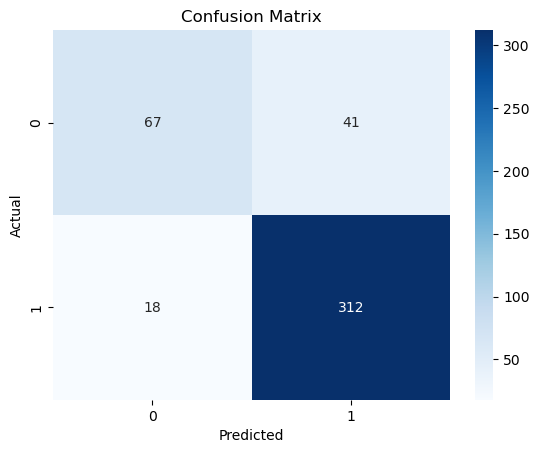

In [43]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

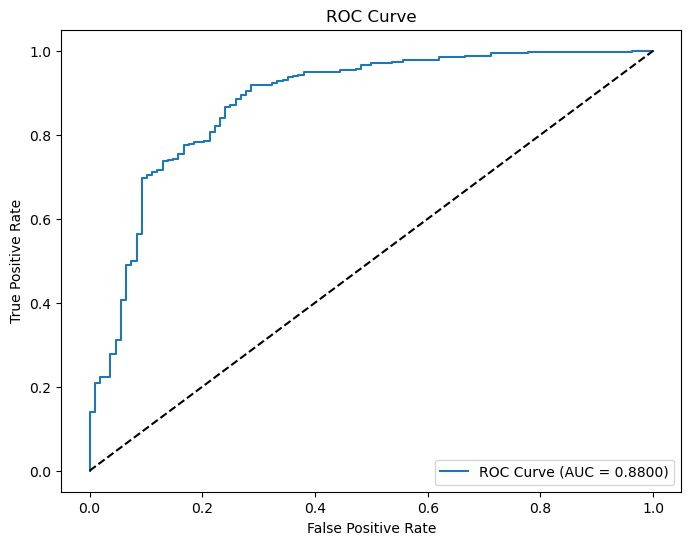

In [44]:
# ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()